Exploring whether digestion method tends to bias based on hydrophobicity

In [1]:
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE 

In [2]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',
                               database='expression_atlas_cells')
mycursor = conn.cursor(buffered=True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


# Calculating GRAVY (hydrophobicity)

In [3]:
# Source: https://www.thermofisher.com/be/en/home/references/ambion-tech-support/rna-tools-and-calculators/proteins-and-amino-acids.html
mol_weights =   {'A': 89.1,
                'R': 174.2,
                'N': 132.1,
                'D': 133.1,
                'C': 121.2,
                'E': 147.1,
                'Q': 146.2,
                'G': 75.1,
                'H': 155.2,
                'I': 131.2,
                'L': 131.2,
                'K': 146.2,
                'M': 149.2,
                'F': 165.2,
                'P': 115.1,
                'S': 105.1,
                'T': 119.1,
                'W': 204.2,
                'Y': 181.2,
                'V': 117.1}

def calculateWeight(sequence: str):
    weight = 0
    for AA in sequence:
        if AA not in mol_weights.keys():
            continue
        weight += mol_weights[AA]
    return weight

In [4]:
#Gravy scores of AA; source: https://pubmed.ncbi.nlm.nih.gov/7108955/
GRAVY_SCORES = {
    "I": 4.5,
    "V": 4.2,
    "L": 3.8,
    "F": 2.8,
    "C": 2.5,
    "M": 1.9,
    "A": 1.8,
    "G": -0.4,
    "T": -.7,
    "W": -0.9,
    "S": -0.8,
    "Y": - 1.3,
    "P": -1.6,
    "H": -3.2,
    "E": - 3.5,
    "Q": -3.5,
    "D": -3.5,
    "N": - 3.5,
    "K": -3.9,
    "R": - 4.5
}

def calculateGravy(sequence: str):
    """Calculates Gravy-score of a given protein sequence.
    
    Calculation is based on hydrophibicity score of AA from the following paper: https://pubmed.ncbi.nlm.nih.gov/7108955/
    
    G > 0: more hydrophobic
    G < 0: more hydrophilic"""

    G_score = 0
    for AA in sequence:
        if AA not in GRAVY_SCORES.keys():
            continue
        G_score += GRAVY_SCORES[AA]
    return G_score/len(sequence)

,uniprot_id,sequence,GRAVY
7,A0A024RBG1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,-0.581768
14,A0A075B6H7,MEAPAQLLFLLLLWLPDTTREIVMTQSPPTLSLSPGERVTLSCRAS...,-0.106897
17,A0A075B6I1,MAWTPLLLLFPLLLHCTGSLSQPVLTQSSSASASLGSSVKLTCTLS...,-0.248333
18,A0A075B6I3,MALTPLLLLLLSHCTGSLSRPVLTQPPSLSASPGATARLPCTLSSD...,-0.156098
22,A0A075B6L6,MGTRLLCWAALCLLGADHTGAGVSQTPSNKVTEKGKDVELRCDPIS...,-0.290435


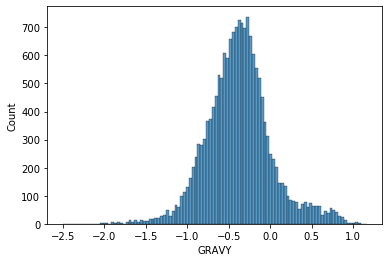

In [5]:
# Get uniprot_ids and sequence from the database and calculate the GRAVY's

query = "SELECT uniprot_id, sequence FROM protein"
uniprot_seq = pd.read_sql(query, conn)
uniprot_seq = uniprot_seq[~uniprot_seq.sequence.isna()]
uniprot_seq["GRAVY"] = uniprot_seq.apply(lambda x: calculateGravy(x["sequence"]), axis = 1)
sns.histplot(uniprot_seq.GRAVY)
uniprot_seq.head()

In [6]:
uniprot_seq = uniprot_seq.filter(items = ["uniprot_id", "GRAVY"]).set_index("uniprot_id")

In [7]:
# Read expression matrix

data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
data = np.exp2(data).fillna(0)

# Get metadata of the samples

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [8]:
def apply_gravy(row):
    column_names = data.columns
    score = 0
    norm = 0

    for i in range(1,len(column_names)-1):

        saf = row.values[i]
        prot = column_names[i]

        if saf != 0.0 and prot in uniprot_seq.index: 
            
            GRAVY = uniprot_seq.loc[prot].values[0] #Take GRAVY score from uniprot_seq table
            score += saf*GRAVY #Update score so there is one complete hydrophobicity score for the proteome
            norm += saf

    # Scores are normalized by the total expression in a sample to get the 'mean hydrophobicity score' of a sample    
    norm_score = score/norm

    return norm_score

In [9]:
data["GRAVY"] = data.apply(lambda x: apply_gravy(x), axis = 1)

# On protein level

In [10]:
meta.experiment_type.value_counts()

in-solution            339
FASP                   129
in-gel                  33
in-gel, in-solution     13
in-solution, FASP        4
Name: experiment_type, dtype: int64

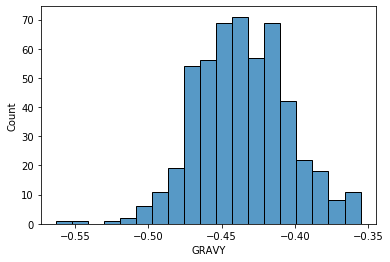

In [11]:
# Distribution of mean hydrophibicity scores of samples
sns.histplot(data.GRAVY)

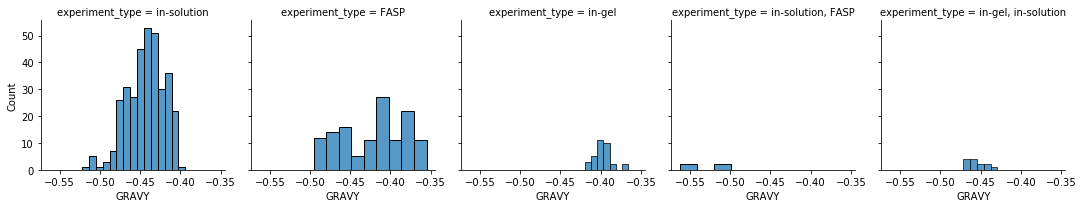

In [19]:
# Plot the same as above but separately for each experiment type

# Form a facetgrid using columns with a hue
sea = sns.FacetGrid(pd.merge(data, meta, left_index=True, right_index=True), col = "experiment_type")
   
# map the above form facetgrid with some attributes  
sea.map(sns.histplot, "GRAVY")
 
# adding legend
sea.add_legend()

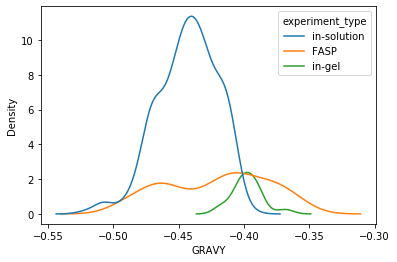

In [21]:
sns.kdeplot(data = pd.merge(data.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index, :], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), x = "GRAVY", hue = "experiment_type", common_norm=True)

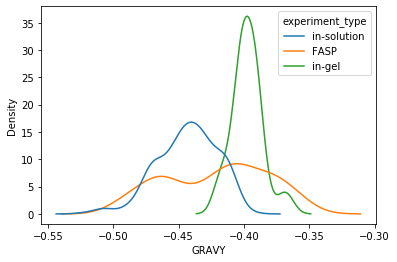

In [12]:
sns.kdeplot(data = pd.merge(data.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index, :], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), x = "GRAVY", hue = "experiment_type", common_norm=False)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


Text(0.5, 0, 'Sample preparation')

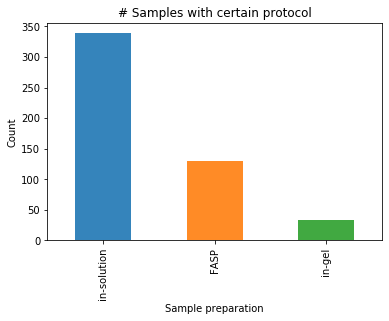

In [41]:
pd.merge(data.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index, :], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True
                            , right_index=True)["experiment_type"].value_counts().plot(kind="bar", colors=sns.color_palette()[:3], alpha=.9)

plt.title("# Samples with certain protocol")
plt.ylabel("Count")
plt.xlabel('Sample preparation')

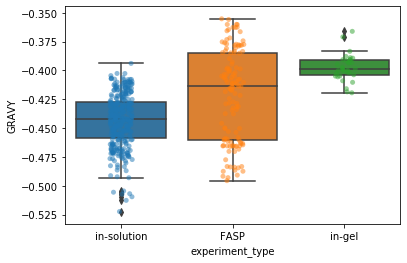

In [33]:
sns.boxplot(data=pd.merge(data.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index, :], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), x="experiment_type", y="GRAVY",
                            saturation=.7)
sns.stripplot(data=pd.merge(data.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index, :], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), x="experiment_type", y="GRAVY",
                            alpha=.5)

In [12]:
on_filter_index = meta[meta.experiment_type == "FASP"].index
in_solution_index = meta[meta.experiment_type == "in-solution"].index
in_gel_index = meta[meta.experiment_type == "in-gel"].index

In [50]:
data.loc[in_solution_index,"GRAVY"]

assay_id
30960   -0.417148
30961   -0.417552
31008   -0.415383
31009   -0.415629
31488   -0.428349
           ...   
36299   -0.437395
36344   -0.442043
36347   -0.424842
36350   -0.410503
36416   -0.467440
Name: GRAVY, Length: 339, dtype: float64

In [16]:
from scipy import stats


filter_vs_solution = stats.ttest_ind(data.loc[on_filter_index,"GRAVY"], data.loc[in_solution_index, "GRAVY"], equal_var = False)[1]
filter_vs_gel = stats.ttest_ind(data.loc[on_filter_index,"GRAVY"], data.loc[in_gel_index, "GRAVY"], equal_var = False)[1]
gel_vs_solution = stats.ttest_ind(data.loc[in_gel_index,"GRAVY"], data.loc[in_solution_index, "GRAVY"], equal_var = False)[1]

print("Welch test, parametric unequal variance")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))

filter_vs_solution = stats.mannwhitneyu(data.loc[on_filter_index,"GRAVY"], data.loc[in_solution_index, "GRAVY"])[1]
filter_vs_gel = stats.mannwhitneyu(data.loc[on_filter_index,"GRAVY"], data.loc[in_gel_index, "GRAVY"])[1]
gel_vs_solution = stats.mannwhitneyu(data.loc[in_gel_index,"GRAVY"], data.loc[in_solution_index, "GRAVY"])[1]

print("Mann whitney test (non parametric)")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))


# TODO: perform other tests (Kruskal Wallis)

Welch test, parametric unequal variance
Filter vs solution:  1.3029502948739332e-08
Filter vs gel:       1.2228390850166636e-08
gel vs solution:     8.128288493284626e-28
Mann whitney test (non parametric)
Filter vs solution:  1.7218070907645628e-09
Filter vs gel:       0.0005899564655579765
gel vs solution:     4.2523305630053576e-20


# On peptide level

In [18]:
meta = pd.read_csv("../../Metadata/unified_metadata.csv")

In [25]:
no_pool = meta[meta.pool_id.isin([0])].assay_id.tolist()
pools = meta[~meta.assay_id.isin(no_pool)].groupby(["PXD_accession", "pool_id"]).apply(lambda x: list(x.assay_id)).tolist()

In [33]:
print("Unpooled")
meta.experiment_type.value_counts()

Unpooled


in-solution            3422
in-gel                  435
FASP                    352
in-solution, FASP        92
in-gel, in-solution      21
Name: experiment_type, dtype: int64

In [8]:
meta2 = pd.read_csv("../Metadata/unified_metadata.csv")
nsaf = pd.read_hdf("../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index="assay_id", columns="uniprot_id", values = "NSAF")

meta2 = meta[meta2.assay_id.isin(nsaf.index)]

In [6]:
# Pooled
meta.groupby("experiment_type").count()

,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,instrument,pmid,pool_id
experiment_type,,,,,,,,,,,,,,,,,,
FASP,146,146,146,146,146,146,146,146,146,0,146,146,146,146,146,146,146,146
in-gel,38,38,38,38,38,38,38,38,38,0,38,38,38,38,38,38,38,38
"in-gel, in-solution",13,13,13,13,13,13,13,13,13,0,13,13,13,13,13,13,13,13
in-solution,420,420,420,420,420,420,420,420,420,0,420,420,420,420,420,420,420,420
"in-solution, FASP",4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4


In [34]:
# Get the peptide counts for each assays and information of the peptides (sequence)

sql_query = "SELECT assay_id, peptide_id, quantification FROM peptide_to_assay"
peptide_assay = pd.read_sql(sql_query, conn)

sql_query = "SELECT * FROM peptide"
peptides = pd.read_sql(sql_query, conn)

In [35]:
# Calculate some attributes
peptides["GRAVY"] = peptides.peptide_sequence.apply(lambda x: calculateGravy(x))
peptides["MolWeight"] = peptides.peptide_sequence.apply(lambda x: calculateWeight(x))
peptides["Length"] = peptides.peptide_sequence.apply(lambda x: len(x))

In [37]:
peptides.loc[:,:]

,peptide_id,peptide_sequence,start_position,GRAVY,MolWeight,Length
0,110730450,SEIVNWYIK,None,-0.077778,1295.4,9
1,110730451,SDGIYIINIK,None,0.460000,1297.6,10
2,110730452,GEMMDIQHGSIFIR,None,0.021429,1868.3,14
3,110730453,IETWHKPDIGTIENVHGIDPNTWK,None,-0.870833,3215.4,24
4,110730454,TMIITHMQDIQEVTQDIHYENFR,None,-0.586957,3259.7,23
...,...,...,...,...,...,...
495078,134379552,ITDVIPPQAINEFTVLVLVNTIYFKGLWK,None,0.703448,3837.3,29
495079,134379581,LWAYLTIQQLLEQMVSALDAEKQALEAR,None,0.082143,3719.4,28
495080,134380085,GFGAPRPR,None,-1.050000,983.1,8
495081,134380397,KVLGCAKEQVDPDSLK,None,-0.512500,2000.3,16


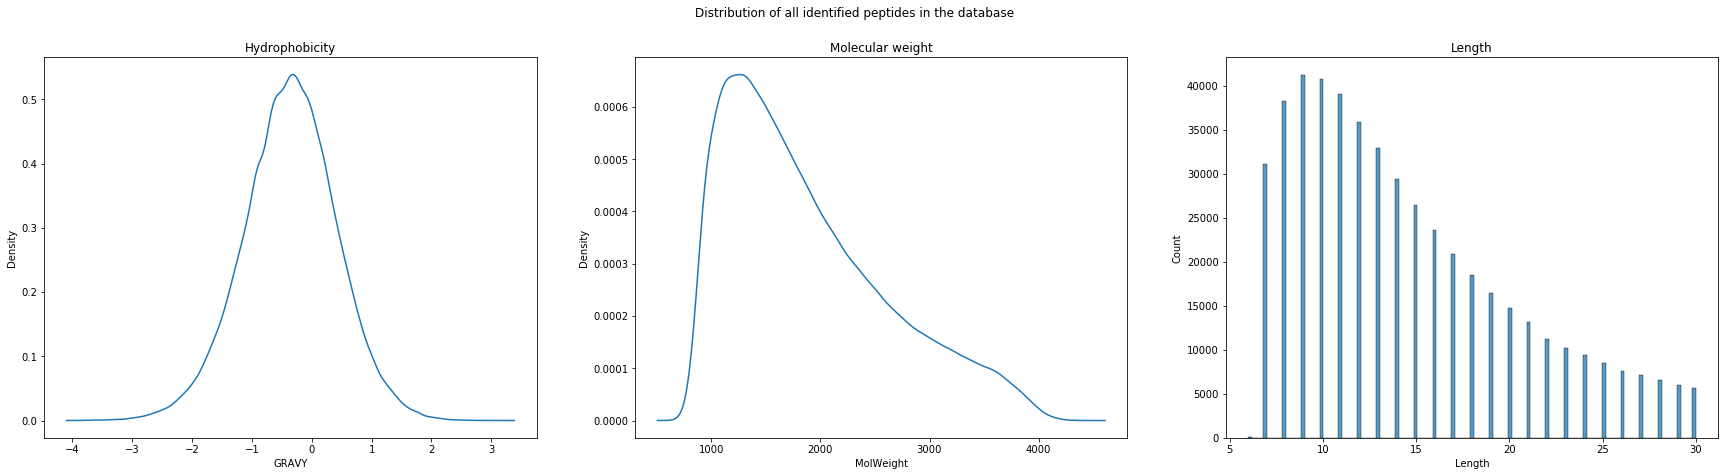

In [38]:
# Plot the attributes of peptides found in the database, regardless of the number of times they are identified
fig, ax = plt.subplots(1,3, figsize=(30,7))

fig.suptitle("Distribution of all identified peptides in the database")
ax[0].set_title("Hydrophobicity")
ax[1].set_title("Molecular weight")
ax[2].set_title("Length")

sns.kdeplot(peptides.GRAVY, ax=ax[0])
sns.kdeplot(peptides.MolWeight, ax=ax[1])
sns.histplot(peptides.Length, ax=ax[2])

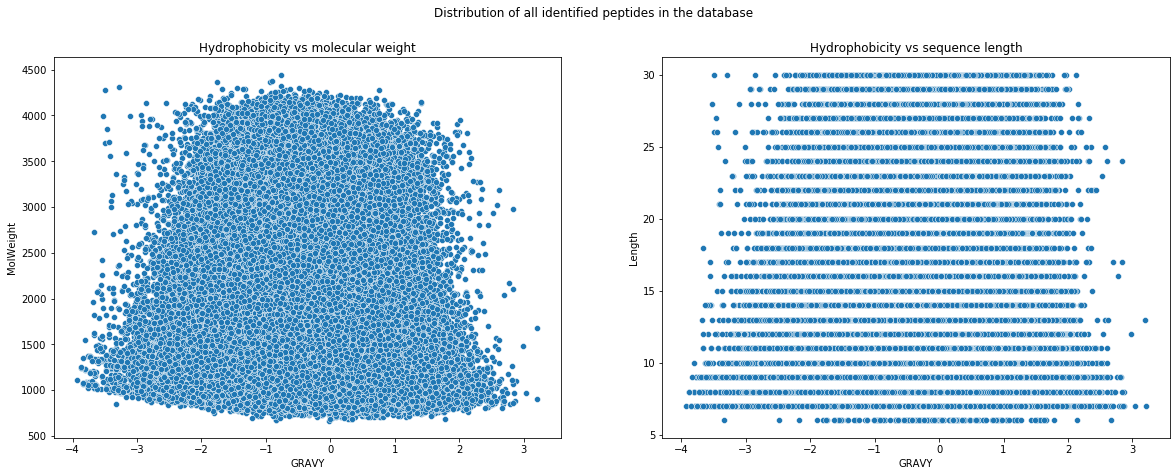

In [42]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

fig.suptitle("Distribution of all identified peptides in the database")
ax[0].set_title("Hydrophobicity vs molecular weight")
ax[1].set_title("Hydrophobicity vs sequence length")

sns.scatterplot(data=peptides, x="GRAVY", y="MolWeight", ax=ax[0])
sns.scatterplot(data=peptides, x="GRAVY", y="Length", ax=ax[1])

In [51]:
peptide_table = pd.merge(peptide_assay, peptides, on = "peptide_id")

In [15]:
# Peptides identified in the MS-files
meta.peptides

0        9705
1       10104
48       9384
49       9593
96       5840
        ...  
4181     1597
4226     1781
4229     1689
4232     1806
4298     1276
Name: peptides, Length: 621, dtype: int64

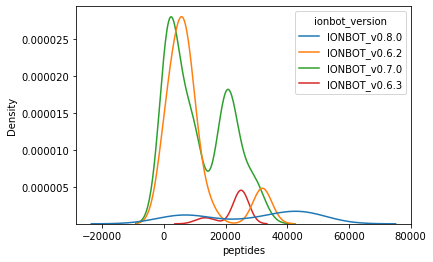

In [17]:
# NOTE: the low peptide identifications is due to fractions
sns.kdeplot(meta.peptides, hue = meta["ionbot_version"])

In [48]:
FASP_assay = meta[(meta.experiment_type == "FASP")].assay_id.tolist()
ingel_assay = meta[(meta.experiment_type == "in-gel")].assay_id.tolist()
in_solution_assay = meta[(meta.experiment_type == "in-solution")].assay_id.tolist()

<BarContainer object of 3 artists>

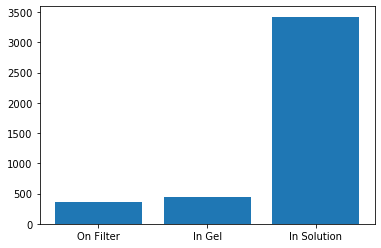

In [49]:
# Counts of samples with certain sample prep (including each fraction as a count)
plt.bar(x=["On Filter", 'In Gel', "In Solution"], height = [len(set(FASP_assay)), len(set(ingel_assay)), len(set(in_solution_assay))])

<BarContainer object of 3 artists>

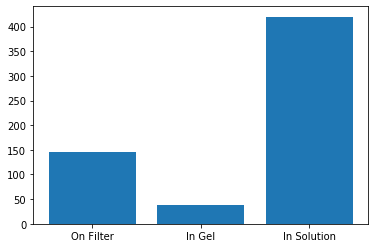

In [15]:
# Counts of samples with certain sample prep
plt.bar(x=["On Filter", 'In Gel', "In Solution"], height = [len(set(FASP_assay)), len(set(ingel_assay)), len(set(in_solution_assay))])

In [53]:
peptide_table.assay_id.nunique()

4414

In [54]:
meta.assay_id.nunique()

4322

In [55]:
peptides_FASP = peptide_table[peptide_table.assay_id.isin(FASP_assay)]
peptides_ingel = peptide_table[peptide_table.assay_id.isin(ingel_assay)]
peptides_solution = peptide_table[peptide_table.assay_id.isin(in_solution_assay)]

In [58]:
from ipywidgets import IntProgress
from IPython.display import display

def summarize_assay_datapoints(table: pd.DataFrame):
    
    # {'GRAVY': {'assay1': x, 'assay2': x}, {'MolWeight}: {'assay1': x, 'assay2': x}}
    dataframe_data = {'GRAVY': {}, 
                      'MolWeight': {},
                      'AvgLength': {}}
    
    assay_ids = table.assay_id.unique()

    f = IntProgress(min=0, max = len(assay_ids))
    display(f)

    # For each assay, compute several metrics
    for assay_id in assay_ids:
        assay_table = table[table.assay_id == assay_id]

        total_quant = 0
        Gravy = 0
        MolWeight = 0
        AvgLength = 0

        # For each peptide in the assay, sum the metrics
        for i, row in assay_table.iterrows():

            total_quant += row["quantification"]
            Gravy += row["GRAVY"] * row["quantification"]
            MolWeight += row["MolWeight"] * row["quantification"]
            AvgLength += row["Length"] * row["quantification"]

        # Normalize them by the amount of peptides identified
        Gravy = Gravy / total_quant
        MolWeight = MolWeight / total_quant
        AvgLength = AvgLength / total_quant

        # Save them in dataframe format
        dataframe_data["GRAVY"][assay_id] = Gravy
        dataframe_data["MolWeight"][assay_id] = MolWeight
        dataframe_data["AvgLength"][assay_id] = AvgLength

        f.value += 1
    
    return pd.DataFrame(dataframe_data)

In [60]:
# Edit to pool samples because fractionation is based on physicochemical properties such as hydrophobicity
def summarize_assay_datapoints(table: pd.DataFrame):
    
    # {'GRAVY': {'assay1': x, 'assay2': x}, {'MolWeight}: {'assay1': x, 'assay2': x}}
    dataframe_data = {'GRAVY': {}, 
                      'MolWeight': {},
                      'AvgLength': {}}
    
    assay_ids = table.assay_id.unique()

    f = IntProgress(min=0, max = len(assay_ids))
    display(f)

    # For each assay, compute several metrics
    
    # For all pooled samples
    for pool_ids in pools:
        total_quant = 0
        Gravy = 0
        MolWeight = 0
        AvgLength = 0
        
        # For each fraction, compute the metrics and sum them across fractions
        for assay_id in pool_ids:
            
            if assay_id in table.assay_id.unique():
     
                assay_table = table[table.assay_id == assay_id]
                
                for i, row in assay_table.iterrows():

                    total_quant += row["quantification"]
                    Gravy += row["GRAVY"] * row["quantification"]
                    MolWeight += row["MolWeight"] * row["quantification"]
                    AvgLength += row["Length"] * row["quantification"]
                
                f.value += 1
    
        if Gravy != 0:

            Gravy = Gravy / total_quant
            MolWeight = MolWeight / total_quant
            AvgLength = AvgLength / total_quant

            dataframe_data["GRAVY"][assay_id] = Gravy
            dataframe_data["MolWeight"][assay_id] = MolWeight
            dataframe_data["AvgLength"][assay_id] = AvgLength


    for assay_id in no_pool:
        if assay_id not in table.assay_id.unique():
            continue
        
        assay_table = table[table.assay_id == assay_id]

        total_quant = 0
        Gravy = 0
        MolWeight = 0
        AvgLength = 0

        # For each peptide in the assay, sum the metrics
        for i, row in assay_table.iterrows():

            total_quant += row["quantification"]
            Gravy += row["GRAVY"] * row["quantification"]
            MolWeight += row["MolWeight"] * row["quantification"]
            AvgLength += row["Length"] * row["quantification"]

        # Normalize them by the amount of peptides identified
        Gravy = Gravy / total_quant
        MolWeight = MolWeight / total_quant
        AvgLength = AvgLength / total_quant

        # Save them in dataframe format
        dataframe_data["GRAVY"][assay_id] = Gravy
        dataframe_data["MolWeight"][assay_id] = MolWeight
        dataframe_data["AvgLength"][assay_id] = AvgLength

        f.value += 1
    
    return pd.DataFrame(dataframe_data)

In [56]:
# Including all fractions
print(peptides_ingel.shape, peptides_solution.shape, peptides_FASP.shape)

(622371, 8) (9740317, 8) (2227029, 8)


In [18]:
# Not all fractions
print(peptides_ingel.shape, peptides_solution.shape, peptides_FASP.shape)

(135280, 8) (2929608, 8) (1242894, 8)


In [61]:
in_gel_df = summarize_assay_datapoints(peptides_ingel)
in_solution_df = summarize_assay_datapoints(peptides_solution)
FASP_df = summarize_assay_datapoints(peptides_FASP)

IntProgress(value=0, max=435)

IntProgress(value=0, max=3422)

IntProgress(value=0, max=352)

In [62]:
in_gel_df["Type"] = "in gel"
in_solution_df["Type"] = "in solution"
FASP_df["Type"] = "on filter"

In [63]:
summary_df = pd.concat([in_gel_df, in_solution_df, FASP_df])
summary_df.head()

,GRAVY,MolWeight,AvgLength,Type
31340,-0.198248,2265.553782,17.706977,in gel
31343,-0.200207,2258.596206,17.655382,in gel
33970,-0.307929,1848.107205,14.353212,in gel
33973,-0.349153,1923.438466,14.957484,in gel
33976,-0.289660,1859.878376,14.456733,in gel


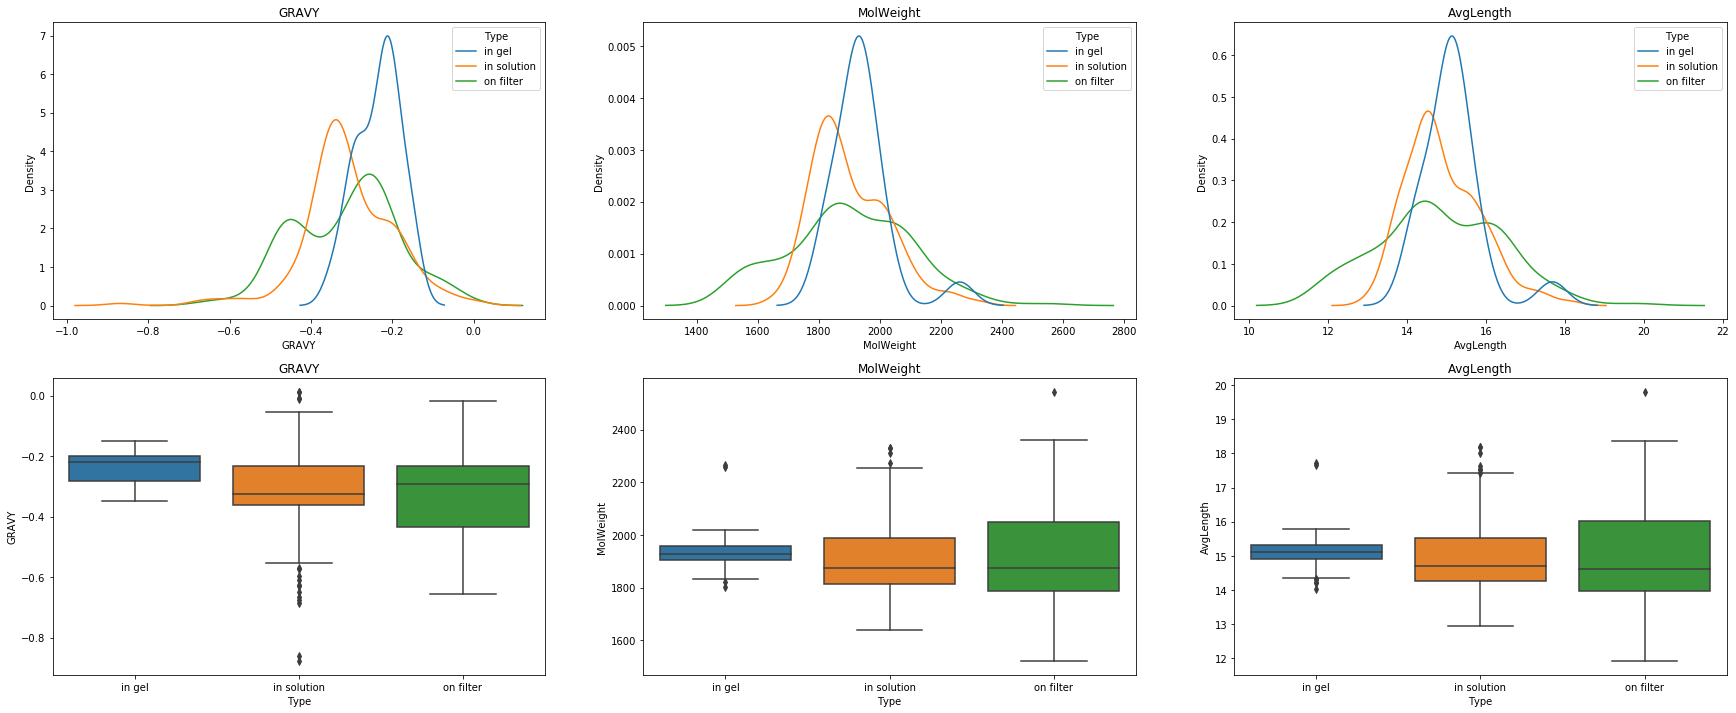

In [64]:
# Plot the mean GRAVY, molecular weight and length of the peptides identified in a sample

fig, ax = plt.subplots(2,3, figsize=(30,12))

ax[0,0].set_title("GRAVY")
sns.kdeplot(summary_df.GRAVY, hue = summary_df.Type, ax = ax[0,0], common_norm=False)

ax[0,1].set_title("MolWeight")
sns.kdeplot(summary_df.MolWeight, hue = summary_df.Type, ax = ax[0,1], common_norm=False)

ax[0,2].set_title("AvgLength")
sns.kdeplot(summary_df.AvgLength, hue = summary_df.Type, ax = ax[0,2], common_norm=False)

ax[1,0].set_title("GRAVY")
sns.boxplot(data=summary_df, x="Type", y="GRAVY", ax=ax[1,0])

ax[1,1].set_title("MolWeight")
sns.boxplot(data=summary_df, x="Type", y="MolWeight", ax=ax[1,1])

ax[1,2].set_title("AvgLength")
sns.boxplot(data=summary_df, x="Type", y="AvgLength", ax=ax[1,2])

In [65]:
from scipy import stats
print(stats.ttest_ind(summary_df[summary_df.Type == "in gel"].GRAVY, summary_df[summary_df.Type == "on filter"].GRAVY),
      stats.ttest_ind(summary_df[summary_df.Type == "in gel"].GRAVY, summary_df[summary_df.Type == "in solution"].GRAVY))

Ttest_indResult(statistic=3.719062234725612, pvalue=0.0002661575932072586) Ttest_indResult(statistic=3.9616479799755013, pvalue=8.635792038106815e-05)


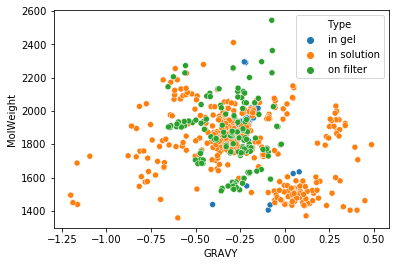

In [75]:
sns.scatterplot(x=summary_df.GRAVY, y=summary_df.MolWeight, hue = summary_df.Type)

# TODO

See which proteins are identified in the sample preps and plot their GRAVY distribution regardless of quantification. Also make venn plots to see how large the overlap is